# 英语阅读APP用户学校类型预测

TASK 5+王沛然

导入必要的包

In [1]:
import numpy as np #数据处理
import pandas as pd #数据处理
import matplotlib.pyplot as plt #可视化
import graphviz #画决策树
import warnings #警告

from sklearn.model_selection import train_test_split #测试集训练集分裂
from sklearn.model_selection import cross_val_score #交叉验证
from sklearn import tree #决策树建模
from sklearn.ensemble import RandomForestClassifier #随机森林建模
from sklearn.linear_model import LogisticRegression #逻辑回归建模
from sklearn.metrics import accuracy_score #精度

plt.rcParams['font.sans-serif'] ='Microsoft Yahei' #显示中文：微软雅黑
warnings.filterwarnings('ignore') #不显示警告
%matplotlib inline

## 一、背景介绍与研究问题

用户在注册APP时通常需要填一些个人信息，但是有的用户填写信息并不完整，导致有的信息有缺失值，以至于商家不方便根据用户信息进行合理推荐。因此，对于有缺失信息的用户，可以根据其他信息对该缺失信息进行预测，根据预测结果进行推荐，提高用户的黏性和付费率。<br>以某英语阅读APP的用户数据为例，个人信息中的学校类型有部分缺失值，可以根据其他变量对这部分用户的学校进行预测，根据其登陆行为和学习行为判断用户所处的学校层次，根据预测结果推荐不同难度的英语阅读内容。

## 二、数据说明

本文筛选近期登录过APP并完成至少一篇阅读的用户为该英语阅读APP的活跃用户，最终共获得15356条APP活跃用户在2019年9月-10月的学习数据。每一条数据共获取12个变量，选取“学校类型”为研究的因变量，变量具体信息如下表所示。

|变量类型|变量名|变量说明|取值范围|备注|
|-|-|-|-|-|
|**1.付费行为**|是否付费|定性变量|是、否|付费率卫1.59%|
|**2.个人信息**|学校类型|定性变量|985、211、本科、专科、未知|本科占比最多，为62.03%|
|**3.登录行为**|最大登录天数|单位：天|[1,174]|-|||**3.登录行为**|浏览文章天数|单位：天|[1,174]|-|
|**3.登录行为**|浏览文章数|单位：篇|[1,174]|-|
|**4.学习行为**|答题完成率|连续型变量|[0,1]|答题练习文章数/浏览文章数|
|**4.学习行为**|朗读完成率|连续型变量|[0,1]|朗读练习文章数/浏览文章数|
|**4.学习行为**|拓展完成率|连续型变量|[0,1]|拓展练习文章数/浏览文章数|
|**4.学习行为**|写译完成率|连续型变量|[0,1]|写译练习文章数/浏览文章数|
|**5.优惠领取**|是否领取15天会员包|定性变量|是、否|85.6%已领取|
|**5.优惠领取**|是否领取教师pass卡|定性变量|是、否|34.9%已领取|
|**6.教学关系**|是否有老师|定性变量|是、否|是占比78.52%|

其中，“领取15天会员包”和“领取教师PASS卡”为该英语阅读APP提供的两项优惠活动。当用户注册并登记好个人信息后，即可领取15天会员包。在个人信息填写中如果用户有实名认证的老师，老师发放使用推进PASS卡，学生扫码后可延长1个月使用时间。

## 三、描述性分析

### （一）数据准备

In [2]:
#读取数据
data = pd.read_csv('data.csv', encoding = 'gbk', usecols = ['SCHOOL','MAXLOGIN','DAYREAD','ARTNUM','ISPAY','EXERATE','READRATE','EXTENDRATE','TRANSRATE'])
#变量名更改为中文
data.columns = ['学校类型','最大登陆天数','浏览文章天数','浏览文章数','是否付费','答题完成率','朗读完成率','扩展完成率','写译完成率']
#查看数据前5行
data.head()

,学校类型,最大登陆天数,浏览文章天数,浏览文章数,是否付费,答题完成率,朗读完成率,扩展完成率,写译完成率
0,未知,141,1,1,否,0.0,1.0,0.0,0.0
1,未知,123,1,1,否,1.0,0.0,1.0,0.0
2,未知,165,1,1,否,1.0,0.0,1.0,0.0
3,未知,167,1,1,否,1.0,0.0,0.0,0.0
4,未知,138,1,1,否,0.0,0.0,0.0,0.0


In [3]:
#探索数据，没有缺失值
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15356 entries, 0 to 15355
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   学校类型    15356 non-null  object 
 1   最大登陆天数  15356 non-null  int64  
 2   浏览文章天数  15356 non-null  int64  
 3   浏览文章数   15356 non-null  int64  
 4   是否付费    15356 non-null  object 
 5   答题完成率   15356 non-null  float64
 6   朗读完成率   15356 non-null  float64
 7   扩展完成率   15356 non-null  float64
 8   写译完成率   15356 non-null  float64
dtypes: float64(4), int64(3), object(2)
memory usage: 1.1+ MB


### （二）描述性分析

#### 1.因变量：学校类型

In [4]:
data.学校类型.unique() #学校类型的所有取值

array(['未知', '本科', '211', '985', '专科'], dtype=object)

In [5]:
#各学校类型的人数及所占比例
print('专科：',sum(data.学校类型 == '专科'),round(sum(data.学校类型 == '专科')/data.学校类型.count(), 4))
print('本科：',sum(data.学校类型 == '本科'),round(sum(data.学校类型 == '本科')/data.学校类型.count(), 4))
print('211：',sum(data.学校类型 == '211'),round(sum(data.学校类型 == '211')/data.学校类型.count(), 4))
print('985：',sum(data.学校类型 == '985'),round(sum(data.学校类型 == '985')/data.学校类型.count(), 4))
print('未知：',sum(data.学校类型 == '未知'),round(sum(data.学校类型 == '未知')/data.学校类型.count(), 4))

专科： 933 0.0608
本科： 9526 0.6203
211： 1601 0.1043
985： 734 0.0478
未知： 2562 0.1668


解读：普通本科学校的用户最多，有9526人，占比62.08%；985学校的用户最少，有734人，占比4.78%；另外，专科学校有933人，占比6.08%；211学校有1601人，占比10.43%；未知学校的用户有2562人，占比16.68%。

#### 2.最大登陆天数VS学校类型

Text(0, 0.5, '最大登陆天数')

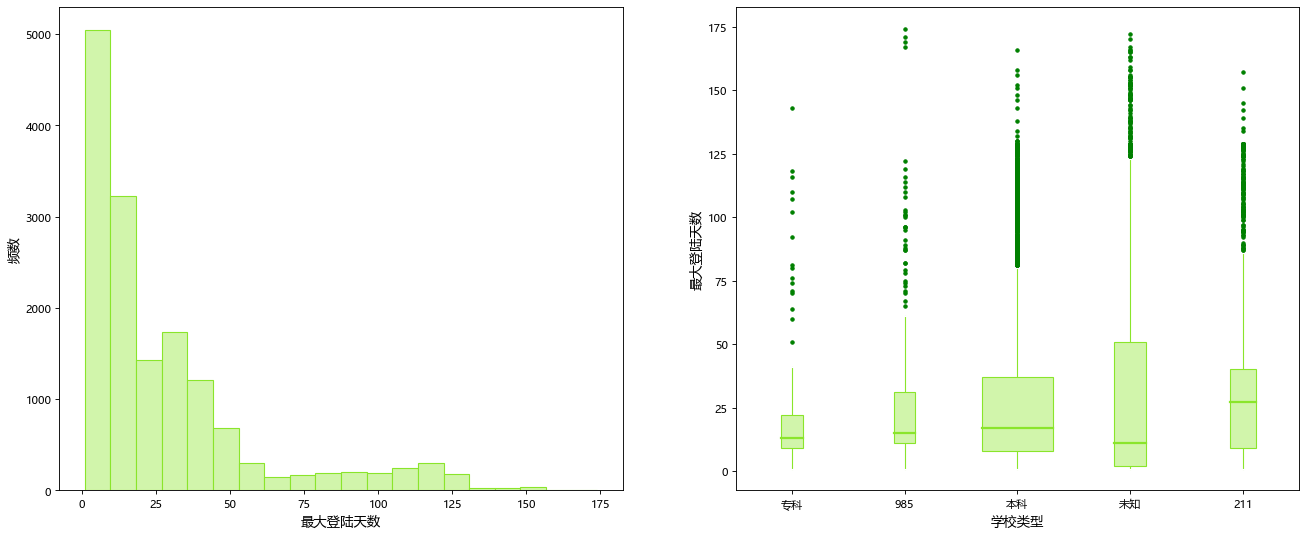

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (20,8), dpi = 80)

#绘制直方图
ax1.hist(x = data.最大登陆天数, bins = 20, color = '#D1F5AB', edgecolor = '#8AE52B')

#装饰直方图
ax1.set_xlabel('最大登陆天数', fontdict = {'fontsize':12}) #x轴
ax1.set_ylabel('频数', fontdict = {'fontsize':12}) #y轴

#绘制箱线图
ax2.boxplot([data[data.学校类型 == label]['最大登陆天数'].tolist() for label in data.groupby('学校类型').mean()['最大登陆天数'].sort_values().index.tolist()]
           ,widths = [(data.学校类型.value_counts()[sch]+3000)/20000 for sch in data.groupby('学校类型').mean()['最大登陆天数'].sort_values().index.tolist()]
           ,labels = data.groupby('学校类型').mean()['最大登陆天数'].sort_values().index.tolist()
           ,boxprops = {'facecolor':'#D1F5AB', 'color':'#8AE52B'} #箱线图的填充色和边框色
           ,capprops = {'color':'white'} #箱线图顶端和末端线条
           ,whiskerprops = {'color':'#8AE52B'} #须
           ,medianprops = {'linestyle':'-','linewidth':2,'color':'#8AE52B'} #中位数线
           ,sym = 'g.' #异常点
           ,patch_artist = True #不生成Line2D
           )

#装饰箱线图
ax2.set_xlabel('学校类型', fontdict = {'fontsize':12}) #y轴
ax2.set_ylabel('最大登陆天数', fontdict = {'fontsize':12}) #x轴

解读：由最大登陆天数的直方图可以看出，最大登陆天数呈右偏分布，大部分集中于1-40天。由箱线图的排列顺序可以看出最大登陆天数均值最大的是专科学校的用户，最小的是211学校的用户；最大登陆天数中位数最大的是211学校的用户，最小的是专科学校用户；在已知学校中，除了211学校用户的最大登陆天数呈左偏分布外，其他学校用户的最大登陆天数均呈右偏分布；最大登陆天数的最大值是985学校的用户。

#### 3.浏览文章天数VS学校类型

Text(0, 0.5, '浏览文章天数（对数变换）')

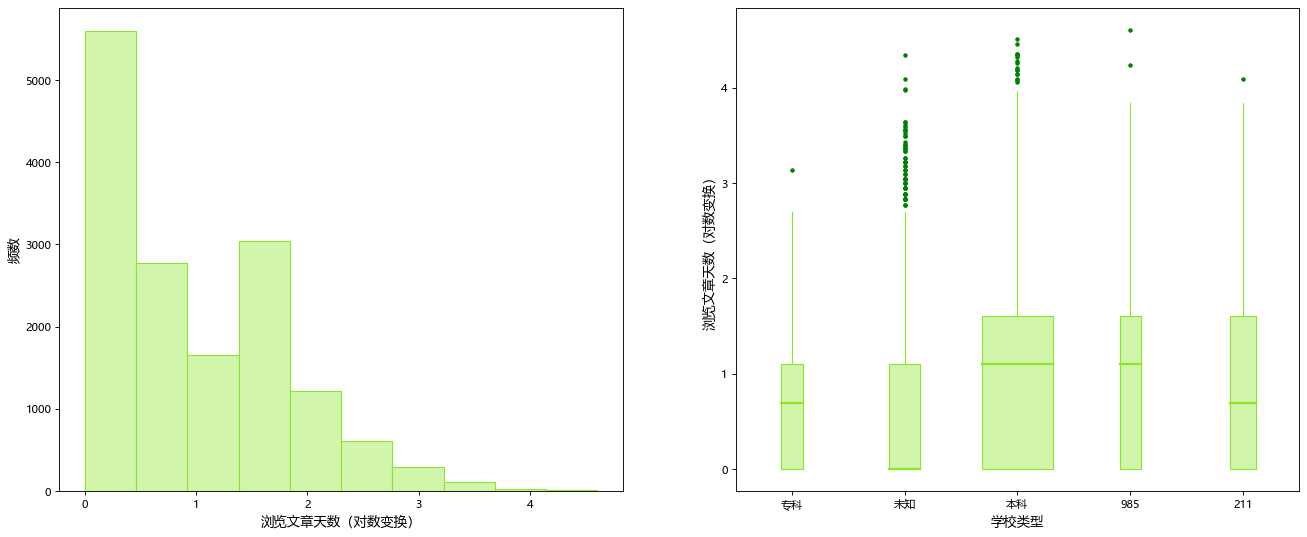

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (20,8), dpi = 80)

#绘制直方图
ax1.hist(x = np.log(data.浏览文章天数), bins = 10, color = '#D1F5AB', edgecolor = '#8AE52B')

#装饰直方图
ax1.set_xlabel('浏览文章天数（对数变换）', fontdict = {'fontsize':12}) #x轴
ax1.set_ylabel('频数', fontdict = {'fontsize':12}) #y轴

#绘制箱线图
ax2.boxplot([np.log(data[data.学校类型 == label]['浏览文章天数'].tolist()) for label in data.groupby('学校类型').mean()['浏览文章天数'].sort_values().index.tolist()]
           ,widths = [(data.学校类型.value_counts()[sch]+3000)/20000 for sch in data.groupby('学校类型').mean()['浏览文章天数'].sort_values().index.tolist()]
           ,labels = data.groupby('学校类型').mean()['浏览文章天数'].sort_values().index.tolist()
           ,boxprops = {'facecolor':'#D1F5AB', 'color':'#8AE52B'} #箱线图的填充色和边框色
           ,capprops = {'color':'white'} #箱线图顶端和末端线条
           ,whiskerprops = {'color':'#8AE52B'} #须
           ,medianprops = {'linestyle':'-','linewidth':2,'color':'#8AE52B'} #中位数线
           ,sym = 'g.' #异常点
           ,patch_artist = True #不生成Line2D
           )

#装饰箱线图
ax2.set_xlabel('学校类型', fontdict = {'fontsize':12}) #y轴
ax2.set_ylabel('浏览文章天数（对数变换）', fontdict = {'fontsize':12}) #x轴

解读：由浏览文章天数（对数变换）的直方图可以看出，浏览文章天数（对数变换）呈右偏分布。由箱线图的排列顺序可以看出浏览文章天数（对数变换）均值最大的是211学校的用户，最小的是专科学校的用户；浏览文章天数（对数变换）中位数最大的是本科和985学校的用户，最小的是211学校用户；在已知学校中，除了211学校用户的最大登陆天数呈右偏分布外，其他学校用户的最大登陆天数均呈左偏分布；浏览文章天数（对数变换）的最大值是985学校的用户。

#### 4.是否付费VS学校类型

In [8]:
data.是否付费.unique() #是否付费的所有取值

array(['否', '是'], dtype=object)

In [9]:
#付费与未付费用户的人数及所占比例
print('付费用户：',sum(data.是否付费 == '是'),round(sum(data.是否付费 == '是')/data.是否付费.count(), 4))
print('未付费用户：',sum(data.是否付费 == '否'),round(sum(data.是否付费 == '否')/data.是否付费.count(), 4))

付费用户： 244 0.0159
未付费用户： 15112 0.9841


解读：付费用户有244人，占比1.59%，未付费用户有15112人，占比98.41%，未付费用户比例远远高于付费用户比例。

In [10]:
#准备条形图数据
PayVSUniversity = pd.merge(pd.DataFrame(data.groupby(['学校类型','是否付费']).size()).reset_index(), pd.DataFrame(data.groupby('学校类型').size()).reset_index(), how = 'left', on = '学校类型')
PayVSUniversity.columns = ['学校类型','是否付费','用户数量（学校类型&是否付费）','用户数量（学校类型）']
PayVSUniversity['百分比'] = PayVSUniversity['用户数量（学校类型&是否付费）']/PayVSUniversity['用户数量（学校类型）']
PayVSUniversity

,学校类型,是否付费,用户数量（学校类型&是否付费）,用户数量（学校类型）,百分比
0,211,否,1579,1601,0.986259
1,211,是,22,1601,0.013741
2,985,否,696,734,0.948229
3,985,是,38,734,0.051771
4,专科,否,932,933,0.998928
5,专科,是,1,933,0.001072
6,未知,否,2502,2562,0.976581
7,未知,是,60,2562,0.023419
8,本科,否,9403,9526,0.987088
9,本科,是,123,9526,0.012912


Text(0, 0.5, '比例')

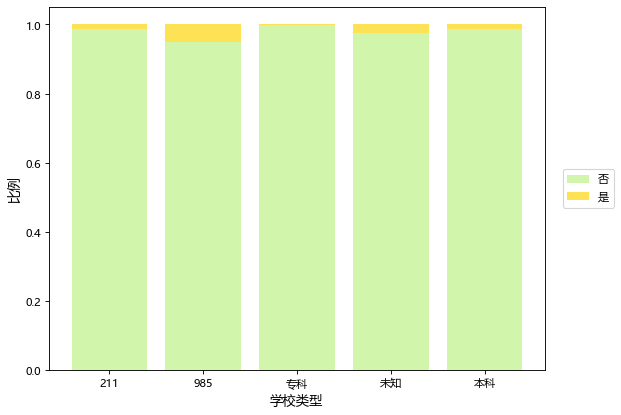

In [11]:
plt.figure(figsize = (8,6), dpi = 80)

#绘制条形图
plt.bar(PayVSUniversity['学校类型'].unique().tolist()
       ,PayVSUniversity['百分比'][0:len(PayVSUniversity):2].values.tolist()
       ,label = '否'
       ,color = '#D1F5AB'
       )
plt.bar(PayVSUniversity['学校类型'].unique().tolist()
       ,PayVSUniversity['百分比'][1:len(PayVSUniversity):2].values.tolist()
       ,label = '是'
       ,color = '#FDE255'
       ,bottom = PayVSUniversity['百分比'][0:len(PayVSUniversity):2].values.tolist()
       )
plt.legend(loc = 'right', bbox_to_anchor=(1.15, 0.5))
plt.xlabel('学校类型', fontsize = 12)
plt.ylabel('比例', fontsize = 12)

解读：由条形图可以看出，985学校用户的付费比例最高，专科学校用户的付费比例最低。

#### 5.学习行为VS学校类型

In [12]:
#定义函数，将学习行为的特征变为分类变量
def categories(x):
    if x == 0:
        return '0'
    elif x == 1:
        return '1'
    else:
        return '(0,1)'

In [13]:
#将学习行为转化为分类变量
behaviour = data[['学校类型','答题完成率','朗读完成率','扩展完成率','写译完成率']]
behaviour["答题完成率（分类）"] = data['答题完成率'].apply(categories)
behaviour["朗读完成率（分类）"] = data['朗读完成率'].apply(categories)
behaviour["扩展完成率（分类）"] = data['扩展完成率'].apply(categories)
behaviour["写译完成率（分类）"] = data['写译完成率'].apply(categories)
behaviour

,学校类型,答题完成率,朗读完成率,扩展完成率,写译完成率,答题完成率（分类）,朗读完成率（分类）,扩展完成率（分类）,写译完成率（分类）
0,未知,0.000000,1.000000,0.000000,0.000000,0,1,0,0
1,未知,1.000000,0.000000,1.000000,0.000000,1,0,1,0
2,未知,1.000000,0.000000,1.000000,0.000000,1,0,1,0
3,未知,1.000000,0.000000,0.000000,0.000000,1,0,0,0
4,未知,0.000000,0.000000,0.000000,0.000000,0,0,0,0
...,...,...,...,...,...,...,...,...,...
15351,本科,0.991870,0.845528,0.948509,0.951220,"(0,1)","(0,1)","(0,1)","(0,1)"
15352,本科,0.994595,0.997297,0.894595,0.937838,"(0,1)","(0,1)","(0,1)","(0,1)"
15353,本科,0.994695,0.994695,0.893899,0.992042,"(0,1)","(0,1)","(0,1)","(0,1)"
15354,本科,0.986772,1.000000,0.857143,0.989418,"(0,1)",1,"(0,1)","(0,1)"


In [14]:
#准备条形图数据
exerate = pd.merge(pd.DataFrame(behaviour.groupby(['学校类型','答题完成率（分类）']).size()).reset_index(), pd.DataFrame(behaviour.groupby('学校类型').size()).reset_index(), how = 'left', on = '学校类型')
exerate.columns = ['学校类型','是否付费','用户数量（学校类型&答题完成率（分类））','答题完成率（分类）']
exerate['答题完成率百分比'] = exerate['用户数量（学校类型&答题完成率（分类））']/exerate['答题完成率（分类）']

readrate = pd.merge(pd.DataFrame(behaviour.groupby(['学校类型','朗读完成率（分类）']).size()).reset_index(), pd.DataFrame(behaviour.groupby('学校类型').size()).reset_index(), how = 'left', on = '学校类型')
readrate.columns = ['学校类型','是否付费','用户数量（学校类型&朗读完成率（分类））','朗读完成率（分类）']
readrate['朗读完成率百分比'] = readrate['用户数量（学校类型&朗读完成率（分类））']/readrate['朗读完成率（分类）']

extendrage = pd.merge(pd.DataFrame(behaviour.groupby(['学校类型','扩展完成率（分类）']).size()).reset_index(), pd.DataFrame(behaviour.groupby('学校类型').size()).reset_index(), how = 'left', on = '学校类型')
extendrage.columns = ['学校类型','是否付费','用户数量（学校类型&扩展完成率（分类））','扩展完成率（分类）']
extendrage['扩展完成率百分比'] = extendrage['用户数量（学校类型&扩展完成率（分类））']/extendrage['扩展完成率（分类）']

transrate = pd.merge(pd.DataFrame(behaviour.groupby(['学校类型','写译完成率（分类）']).size()).reset_index(), pd.DataFrame(behaviour.groupby('学校类型').size()).reset_index(), how = 'left', on = '学校类型')
transrate.columns = ['学校类型','是否付费','用户数量（学校类型&写译完成率（分类））','写译完成率（分类）']
transrate['写译完成率百分比'] = transrate['用户数量（学校类型&写译完成率（分类））']/transrate['写译完成率（分类）']
transrate

,学校类型,是否付费,用户数量（学校类型&写译完成率（分类））,写译完成率（分类）,写译完成率百分比
0,211,"(0,1)",533,1601,0.332917
1,211,0,734,1601,0.458463
2,211,1,334,1601,0.208620
3,985,"(0,1)",237,734,0.322888
4,985,0,341,734,0.464578
5,985,1,156,734,0.212534
6,专科,"(0,1)",247,933,0.264737
7,专科,0,457,933,0.489818
8,专科,1,229,933,0.245445
9,未知,"(0,1)",602,2562,0.234973


Text(0, 0.5, '写译完成率频率')

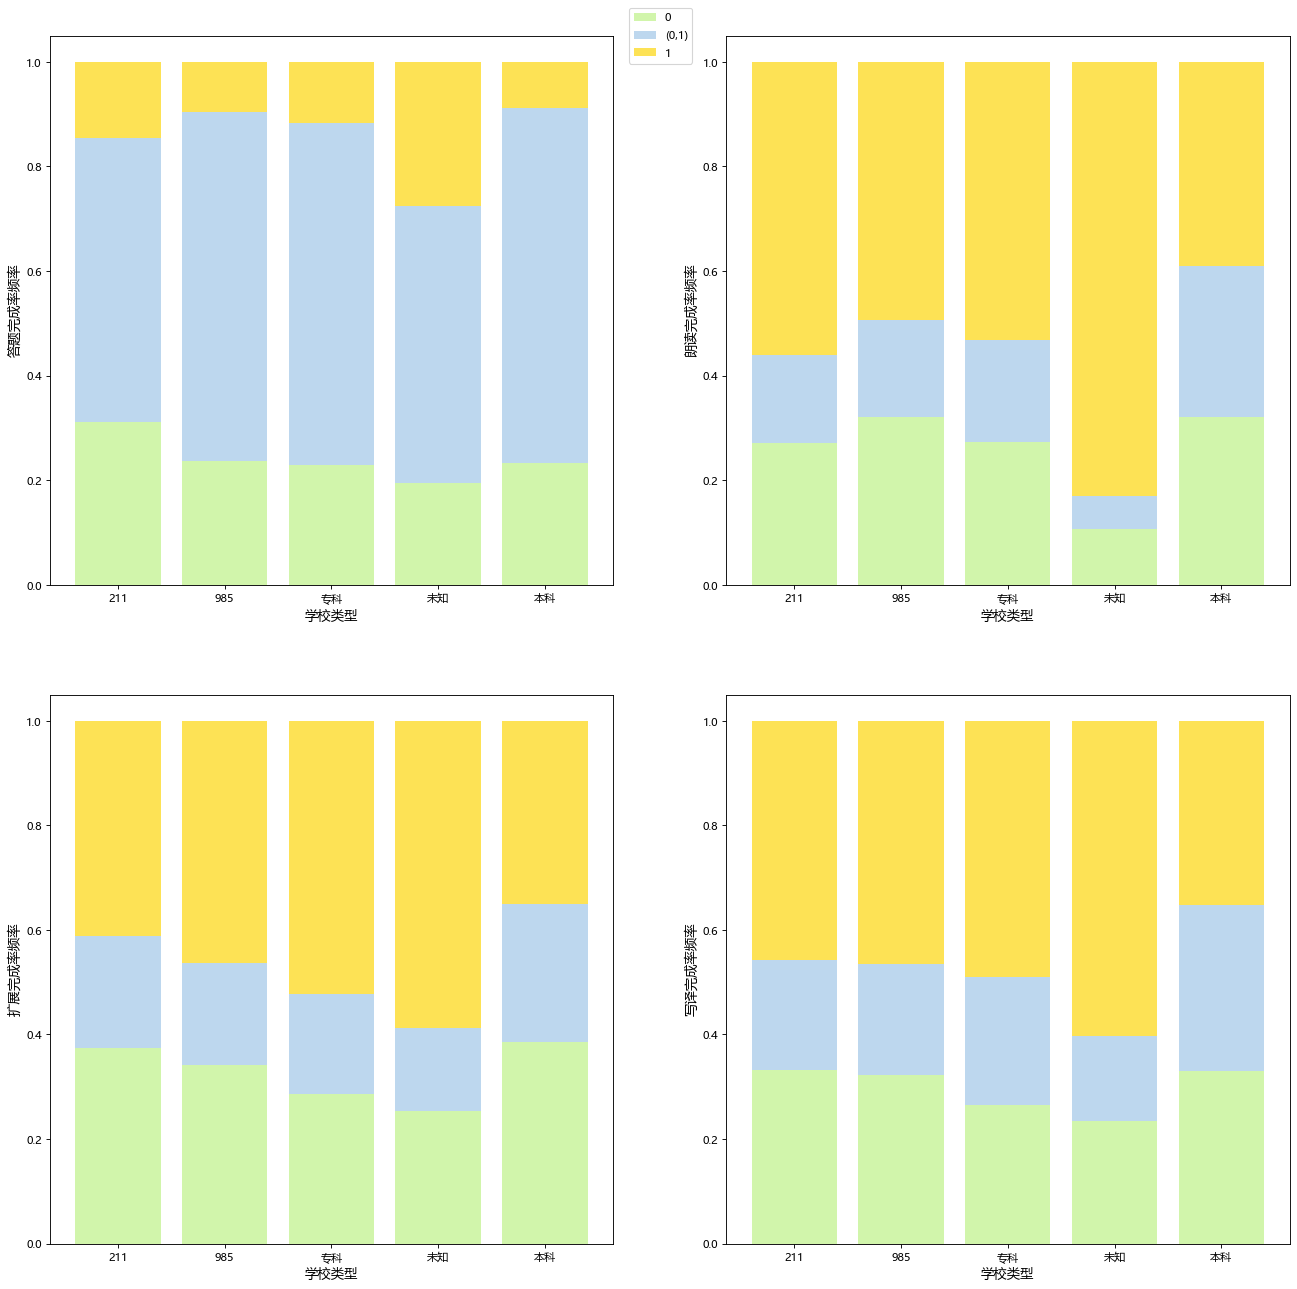

In [15]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize = (20,20), dpi = 80)

#绘制条形图
ax1.bar(exerate['学校类型'].unique().tolist()
       ,exerate['答题完成率百分比'][0:len(exerate):3].values.tolist()
       ,label = '0'
       ,color = '#D1F5AB'
       )
ax1.bar(exerate['学校类型'].unique().tolist()
       ,exerate['答题完成率百分比'][2:len(exerate):3].values.tolist()
       ,label = '(0,1)'
       ,color = '#BDD7EE'
       ,bottom = exerate['答题完成率百分比'][0:len(exerate):3].values.tolist()
       )
ax1.bar(exerate['学校类型'].unique().tolist()
       ,exerate['答题完成率百分比'][1:len(exerate):3].values.tolist()
       ,label = '1'
       ,color = '#FDE255'
       ,bottom = (np.array(exerate['答题完成率百分比'][0:len(exerate):3].values.tolist())+np.array(exerate['答题完成率百分比'][2:len(exerate):3].values.tolist())).tolist()
       )
ax1.legend(loc = 'right', bbox_to_anchor=(1.15, 1)) #图例
ax1.set_xlabel('学校类型', fontdict = {'fontsize':12}) #x轴
ax1.set_ylabel('答题完成率频率', fontdict = {'fontsize':12}) #y轴

ax2.bar(readrate['学校类型'].unique().tolist()
       ,readrate['朗读完成率百分比'][0:len(readrate):3].values.tolist()
       ,label = '0'
       ,color = '#D1F5AB'
       )
ax2.bar(readrate['学校类型'].unique().tolist()
       ,readrate['朗读完成率百分比'][2:len(readrate):3].values.tolist()
       ,label = '(0,1)'
       ,color = '#BDD7EE'
       ,bottom = readrate['朗读完成率百分比'][0:len(readrate):3].values.tolist()
       )
ax2.bar(readrate['学校类型'].unique().tolist()
       ,readrate['朗读完成率百分比'][1:len(readrate):3].values.tolist()
       ,label = '1'
       ,color = '#FDE255'
       ,bottom = (np.array(readrate['朗读完成率百分比'][0:len(readrate):3].values.tolist())+np.array(readrate['朗读完成率百分比'][2:len(readrate):3].values.tolist())).tolist()
       )
ax2.set_xlabel('学校类型', fontdict = {'fontsize':12}) #x轴
ax2.set_ylabel('朗读完成率频率', fontdict = {'fontsize':12}) #y轴

ax3.bar(extendrage['学校类型'].unique().tolist()
       ,extendrage['扩展完成率百分比'][0:len(extendrage):3].values.tolist()
       ,label = '0'
       ,color = '#D1F5AB'
       )
ax3.bar(extendrage['学校类型'].unique().tolist()
       ,extendrage['扩展完成率百分比'][2:len(extendrage):3].values.tolist()
       ,label = '(0,1)'
       ,color = '#BDD7EE'
       ,bottom = extendrage['扩展完成率百分比'][0:len(extendrage):3].values.tolist()
       )
ax3.bar(extendrage['学校类型'].unique().tolist()
       ,extendrage['扩展完成率百分比'][1:len(extendrage):3].values.tolist()
       ,label = '1'
       ,color = '#FDE255'
       ,bottom = (np.array(extendrage['扩展完成率百分比'][0:len(extendrage):3].values.tolist())+np.array(extendrage['扩展完成率百分比'][2:len(exerate):3].values.tolist())).tolist()
       )
ax3.set_xlabel('学校类型', fontdict = {'fontsize':12}) #x轴
ax3.set_ylabel('扩展完成率频率', fontdict = {'fontsize':12}) #y轴

ax4.bar(transrate['学校类型'].unique().tolist()
       ,transrate['写译完成率百分比'][0:len(transrate):3].values.tolist()
       ,label = '0'
       ,color = '#D1F5AB'
       )
ax4.bar(transrate['学校类型'].unique().tolist()
       ,transrate['写译完成率百分比'][2:len(transrate):3].values.tolist()
       ,label = '(0,1)'
       ,color = '#BDD7EE'
       ,bottom = transrate['写译完成率百分比'][0:len(transrate):3].values.tolist()
       )
ax4.bar(transrate['学校类型'].unique().tolist()
       ,transrate['写译完成率百分比'][1:len(transrate):3].values.tolist()
       ,label = '1'
       ,color = '#FDE255'
       ,bottom = (np.array(transrate['写译完成率百分比'][0:len(transrate):3].values.tolist())+np.array(transrate['写译完成率百分比'][2:len(transrate):3].values.tolist())).tolist()
       )
ax4.set_xlabel('学校类型', fontdict = {'fontsize':12}) #x轴
ax4.set_ylabel('写译完成率频率', fontdict = {'fontsize':12}) #y轴

解读：用户对朗读的完成率最高。除了未知学校外，专科学校的零完成率最少；对于1完成率，答题完成率和朗读完成率均是211学校最高，扩展完成率和写译完成率均是专科学校最高。

## 三、决策树与随机森林建模

### （一）数据预处理

In [16]:
#将是否付费转化为数字
labels_pay = data['是否付费'].unique().tolist()
data.loc[:,'是否付费'] = data.loc[:,'是否付费'].apply(lambda x:labels_pay.index(x))

#备份数据
dataCopy = data.copy()
validationCopy = dataCopy[dataCopy.学校类型 == '未知']
validationCopy.index = range(len(validationCopy))

#部分变量归一化处理
max_min_scaler = lambda x : (x-np.min(x))/(np.max(x)-np.min(x))
data['最大登陆天数'] = data[['最大登陆天数']].apply(max_min_scaler)
data['浏览文章天数'] = data[['浏览文章天数']].apply(max_min_scaler)
data['浏览文章数'] = data[['浏览文章数']].apply(max_min_scaler)

#将未知学校的数据设为验证集，其他数据用于训练集和测试集
data_ = data[data.学校类型 != '未知']
data_.index = range(len(data_))
validation = data[data.学校类型 == '未知']
validation.index = range(len(validation))
validation_ = validation.iloc[:, validation.columns != '学校类型']

#将学校类型转化为数字
labels_university = data_['学校类型'].unique().tolist()
data_.loc[:,'学校类型'] = data_.loc[:,'学校类型'].apply(lambda x:labels_university.index(x))

#将特征和标签分开
X = data_.iloc[:,data_.columns != '学校类型']
y = data_.iloc[:,data_.columns == '学校类型']

#将数据分为训练集(70%)和测试集(30%)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,y,test_size=0.3,random_state=14)
print('训练集特征矩阵：',Xtrain.shape)
print('训练集标签：',Ytrain.shape)
print('测试集特征矩阵：',Xtest.shape)
print('测试集标签：',Ytest.shape)

#使索引有序
for i in [Xtrain, Xtest, Ytrain, Ytest]:
    i.index = range(i.shape[0])

训练集特征矩阵： (8955, 8)
训练集标签： (8955, 1)
测试集特征矩阵： (3839, 8)
测试集标签： (3839, 1)


### （二）决策树

In [17]:
#建模
clf_tree = tree.DecisionTreeClassifier(random_state=11 #使score固定
                                      ,criterion = 'entropy' #使用熵
                                      ,max_depth = 4 #最大深度
                                      ,min_samples_leaf = 5 #叶子节点最小样本数
                                      ,min_samples_split = 11 #分割节点最小样本数
                                      )
clf_tree = clf_tree.fit(Xtrain, Ytrain)
score_c_test = clf_tree.score(Xtest, Ytest)
print('测试集精确度：',score_c_test)

#查看训练集精确度，判断是否过拟合
score_c_train = clf_tree.score(Xtrain, Ytrain)
print('训练集集精确度：',score_c_train)

#十折交叉验证
score_c_test_ = cross_val_score(clf_tree, X, y, cv=10).mean()
print('十折交叉验证精确度：',score_c_test_)

测试集精确度： 0.7517582703829122
训练集集精确度： 0.7504187604690117
十折交叉验证精确度： 0.6781094238663018


In [18]:
#根节点的重要性
[*zip(Xtrain.columns,clf_tree.feature_importances_)]

[('最大登陆天数', 0.6634504715312349),
 ('浏览文章天数', 0.07289970751222292),
 ('浏览文章数', 0.1999539883579753),
 ('是否付费', 0.0),
 ('答题完成率', 0.0),
 ('朗读完成率', 0.06369583259856673),
 ('扩展完成率', 0.0),
 ('写译完成率', 0.0)]

解读：使用分类决策树预测学校类型，将已知学校的数据集分为训练集（70%）和测试集（30%），使用熵作为判别条件，最大深度为4，叶子节点最小样本数为5，分割节点最小样本数为11，最后在测试集上的精确度约75.18%（测试集中分类正确的样本数/测试集样本数），且与训练集精确度（75.04%）非常接近，不算过拟合；使用十折交叉验证在测试集上的精确度平均约67.81%。最大登陆天数在根节点上的重要性最大。

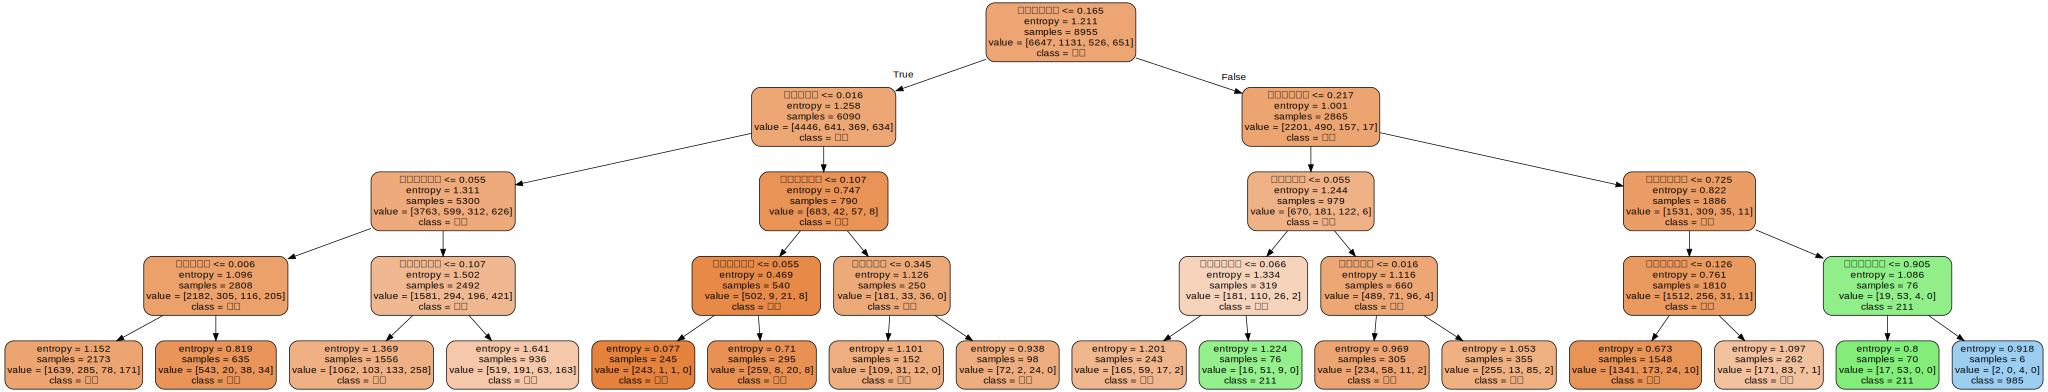

In [19]:
#画决策树
dot_data = tree.export_graphviz(clf_tree #训练的模型的名字
                               ,feature_names = Xtrain.columns #特征的名字
                               ,class_names = labels_university #标签的名字
                               ,filled = True #是否填充颜色，颜色越深不纯度越低
                               ,rounded = True #框形状是否圆
                               )
graph = graphviz.Source(dot_data)
graph

解读：0.165<最大登录天数（归一化后）≤0.217、朗读完成率≤0.055且浏览文章天数（归一化后）>0.066的用户被预测为211学校类型，0.725<最大登陆天数（归一化后）≤0.905的用户被预测为211学校类型，最大登陆天数（归一化后）>0.905的用户被预测为985学校类型，其他均是本科学校类型。

In [20]:
#将验证集中的学校类型替换为预测结果
validation.loc[:,'学校类型'] = clf_tree.predict(validation_)

#定义函数，恢复学校类型的数字为文字
def predictionResult(x):
    if x == 0:
        return '本科'
    elif x == 1:
        return '211'
    elif x == 2:
        return '985'
    else:
        return '专科'

#将数值结果替换为文字
validation['学校类型'] = validation['学校类型'].apply(predictionResult)
validation['最大登陆天数'] = validationCopy['最大登陆天数']
validation['浏览文章天数'] = validationCopy['浏览文章天数']
validation['浏览文章数'] = validationCopy['浏览文章数']
validation

,学校类型,最大登陆天数,浏览文章天数,浏览文章数,是否付费,答题完成率,朗读完成率,扩展完成率,写译完成率
0,211,141,1,1,0,0.000000,1.000000,0.000000,0.000000
1,本科,123,1,1,0,1.000000,0.000000,1.000000,0.000000
2,985,165,1,1,0,1.000000,0.000000,1.000000,0.000000
3,985,167,1,1,0,1.000000,0.000000,0.000000,0.000000
4,211,138,1,1,0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
2557,211,128,77,78,0,0.384615,0.038462,0.012821,0.012821
2558,本科,120,54,84,1,1.000000,0.238095,0.964286,0.988095
2559,本科,87,33,84,0,0.845238,0.559524,0.785714,0.785714
2560,本科,111,60,88,0,0.988636,0.875000,1.000000,0.988636


### （三）随机森林

In [21]:
#建模
clf_rfc = RandomForestClassifier(criterion = 'entropy'
                                ,n_estimators = 200
                                ,random_state = 10
                                ,min_samples_split = 7
                                ,min_samples_leaf = 2
                                ,max_depth = 18
                                )
clf_rfc = clf_rfc.fit(Xtrain, Ytrain)
score_r_test = clf_rfc.score(Xtest, Ytest)
print('测试集精确度：',score_r_test)

#查看训练集精确度，判断是否过拟合
score_r_train = clf_rfc.score(Xtrain, Ytrain)
print('训练集精确度：',score_r_train)

#十折交叉验证
score_r_test_ = cross_val_score(clf_rfc, X, y, cv=10).mean()
print('十折交叉验证精确度：',score_r_test_)

测试集精确度： 0.7770252669966137
训练集精确度： 0.822892238972641
十折交叉验证精确度： 0.6119902633893667


In [22]:
[*zip(Xtrain.columns,clf_rfc.feature_importances_)]

[('最大登陆天数', 0.38060759766375135),
 ('浏览文章天数', 0.11070169349445015),
 ('浏览文章数', 0.1622681633066712),
 ('是否付费', 0.006445725552865699),
 ('答题完成率', 0.07215833636477872),
 ('朗读完成率', 0.10027155571545487),
 ('扩展完成率', 0.08643053747238451),
 ('写译完成率', 0.08111639042964351)]

解读：使用随机森林预测学校类型，将已知学校的数据集分为训练集（70%）和测试集（30%），使用熵作为判别条件，生成200棵树，最大深度为18，叶子节点最小样本数为2，分割节点最小样本数为7，最后在测试集上的精确度约77.70%（测试集中分类正确的样本数/测试集样本数），且与训练集精确度（82.26%）比较接近，不算过拟合；使用十折交叉验证在测试集上的精确度平均约61.20%。最大登陆天数在根节点上的重要性最大。

In [23]:
validation = validationCopy[validationCopy.学校类型 == '未知']
validation.index = range(len(validation))
validation_ = validation.iloc[:, validation.columns != '学校类型']

#将验证集中的学校类型替换为预测结果
validation.loc[:,'学校类型'] = clf_rfc.predict(validation_)

#将数值结果替换为文字
validation['学校类型'] = validation['学校类型'].apply(predictionResult)
validation['最大登陆天数'] = validationCopy['最大登陆天数']
validation['浏览文章天数'] = validationCopy['浏览文章天数']
validation['浏览文章数'] = validationCopy['浏览文章数']
validation

,学校类型,最大登陆天数,浏览文章天数,浏览文章数,是否付费,答题完成率,朗读完成率,扩展完成率,写译完成率
0,本科,141,1,1,0,0.000000,1.000000,0.000000,0.000000
1,本科,123,1,1,0,1.000000,0.000000,1.000000,0.000000
2,本科,165,1,1,0,1.000000,0.000000,1.000000,0.000000
3,本科,167,1,1,0,1.000000,0.000000,0.000000,0.000000
4,本科,138,1,1,0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
2557,本科,128,77,78,0,0.384615,0.038462,0.012821,0.012821
2558,本科,120,54,84,1,1.000000,0.238095,0.964286,0.988095
2559,本科,87,33,84,0,0.845238,0.559524,0.785714,0.785714
2560,本科,111,60,88,0,0.988636,0.875000,1.000000,0.988636


### （四）比较

|比较|决策树|随机森林|
|--|--|--|
|运算速度|快|慢|
|预测精度|低|高|
|计算复杂度|低|高|

## 四、logistic回归建模

In [24]:
#建模
lr = LogisticRegression(random_state = 0 #随机数种子
                       ,penalty = 'l2' #正则化方式
                       ,multi_class= 'multinomial' #多分类问题
                       ,C = 0.3 #正则化强度的倒数
                       ,max_iter = 1000 #求解器收敛的最大迭代次数
                       )
lr = lr.fit(Xtrain, Ytrain)
print('估计系数：\n',lr.coef_)
print('测试集精确度：',accuracy_score(lr.predict(Xtest), Ytest))
print('训练集精确度：',accuracy_score(lr.predict(Xtrain), Ytrain))

#十折交叉验证
lr_test_ = cross_val_score(lr, X, y, cv=10).mean()
print('十折交叉验证精确度：',lr_test_)

估计系数：
 [[ 0.60660406 -0.23501921  0.4086051  -0.31661682 -0.02484441  0.34152801
   0.11724681  0.24374497]
 [ 1.91588762  1.15076847 -0.16794066 -0.22312729 -0.5063412  -0.4089718
   0.51518605 -0.18973188]
 [-0.31091815  0.51359888  0.55992521  1.26775335  0.27729474  0.08850035
  -0.17891279 -0.18971277]
 [-2.21157353 -1.42934814 -0.80058964 -0.72800925  0.25389087 -0.02105656
  -0.45352007  0.13569969]]
测试集精确度： 0.749934878874707
训练集精确度： 0.7422668900055834
十折交叉验证精确度： 0.7444896525605941


解读：使用logistic回归预测学校类型，将已知学校的数据集分为训练集（70%）和测试集（30%），在测试集上的精确度约75.00%（测试集中分类正确的样本数/测试集样本数），且与训练集精确度（74.23%）非常接近，不算过拟合；使用十折交叉验证在测试集上的精确度平均约74.45%。

In [25]:
validation = validationCopy[validationCopy.学校类型 == '未知']
validation.index = range(len(validation))
validation_ = validation.iloc[:, validation.columns != '学校类型']

#将验证集中的学校类型替换为预测结果
validation.loc[:,'学校类型'] = lr.predict(validation_)

#将数值结果替换为文字
validation['学校类型'] = validation['学校类型'].apply(predictionResult)
validation['最大登陆天数'] = validationCopy['最大登陆天数']
validation['浏览文章天数'] = validationCopy['浏览文章天数']
validation['浏览文章数'] = validationCopy['浏览文章数']
validation

,学校类型,最大登陆天数,浏览文章天数,浏览文章数,是否付费,答题完成率,朗读完成率,扩展完成率,写译完成率
0,211,141,1,1,0,0.000000,1.000000,0.000000,0.000000
1,211,123,1,1,0,1.000000,0.000000,1.000000,0.000000
2,211,165,1,1,0,1.000000,0.000000,1.000000,0.000000
3,211,167,1,1,0,1.000000,0.000000,0.000000,0.000000
4,211,138,1,1,0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
2557,211,128,77,78,0,0.384615,0.038462,0.012821,0.012821
2558,211,120,54,84,1,1.000000,0.238095,0.964286,0.988095
2559,211,87,33,84,0,0.845238,0.559524,0.785714,0.785714
2560,211,111,60,88,0,0.988636,0.875000,1.000000,0.988636


**logistic回归的优势：**<br>
（1）对线性关系的拟合效果非常好。特征与标签之间的线性关系极强的数据，比如金融领域中的信用卡欺诈、评分卡制作，电商中的营销预测等相关的数据，都是logistic回归的强项。<br>
（2）计算快。<br>
（3）返回的分类结果不是固定的0、1。而是以小数形式呈现的类概率数字，因此可以把logistic回归返回的结果当成连续型数据来利用。比如在评分卡制作时，不仅需要判断客户是否会违约，还需要给出确定的“信用分”，而信用分的计算就需要使用类概率计算出的对数几率，而决策树和随机森林分类器，可以产出分类结果，却无法计算分数。<br>
（4）抗噪能力强。<br>
（5）在小数据集上表现更好。<br>
**logistic回归的劣势：**<br>
（1）不能用于解决非线性问题。<br>
（2）对多重共线性数据较为敏感。<br>
（3）很难处理数据不平衡问题。